In [1]:
import numpy as np
import torch

from scipy.stats import expon, weibull_min

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

num_samples = 2**14
num_weights = 256
nadir = torch.zeros(1, 2, **tkwargs)
shapes = [0.75, 1.0, 1.5, 2.0]
rate = torch.tensor([1.0, 2.0], **tkwargs)

# Get the samples.
dists = {}
samples = {}
approx_constant = {}
N = 24
for shape in shapes:
    dists[shape] = weibull_min(shape, scale=1 / rate)
    samples[shape] = torch.tensor(dists[shape].rvs(size=(num_samples, 2)), **tkwargs)
    approx_constant[shape] = np.log(N) ** (1 / shape - 1) / shape

# Get the reference fronts.
u = torch.linspace(0, 1, num_weights, **tkwargs).unsqueeze(-1)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(u)

scales = [2.0, 2.0, 2.0, 2.0]
ref_fronts = {}
for i, shape in enumerate(shapes):
    lengths = scales[i] / torch.norm(rate * weights, shape, dim=-1)
    ref_fronts[shape] = nadir + lengths.unsqueeze(-1) * weights

# Get the masks.
masks_upper = {}
masks_lower = {}
for i, shape in enumerate(shapes):
    length = torch.norm(abs(samples[shape] - nadir), 2, dim=-1)
    sample_weights = abs(samples[shape] - nadir) / length.unsqueeze(-1)
    ref_length = scales[i] / torch.norm(rate * sample_weights, shape, dim=-1)
    masks_upper[shape] = length > ref_length
    masks_lower[shape] = length <= ref_length

# Set bounds.
bounds = {}
plot_bounds = {}

manual_upper_bounds = [
    torch.tensor([8.0, 4.0], **tkwargs),
    torch.tensor([6.0, 3.0], **tkwargs),
    torch.tensor([4.0, 2.0], **tkwargs),
    torch.tensor([3.0, 1.5], **tkwargs),
]
for i, shape in enumerate(shapes):
    min_values = nadir
    max_values = manual_upper_bounds[i]
    shift = 0.05 * (max_values - min_values)
    bounds[shape] = torch.row_stack([min_values + 0.000001, max_values])
    plot_bounds[shape] = torch.row_stack([min_values - shift, max_values + shift])

# Get the grids.
grid_length = 128

X1s = {}
X2s = {}
all_Xs = {}

for shape in shapes:
    bound = bounds[shape]
    t1 = torch.linspace(bound[0, 0], bound[1, 0], grid_length, **tkwargs)
    t2 = torch.linspace(bound[0, 1], bound[1, 1], grid_length, **tkwargs)

    X1, X2 = torch.meshgrid(t1, t2, indexing="xy")
    all_X = torch.column_stack(
        [
            X1.reshape(grid_length**2),
            X2.reshape(grid_length**2),
        ]
    )
    X1s[shape] = X1
    X2s[shape] = X2
    all_Xs[shape] = all_X

In [3]:
# Compute the empirical and theoretical probability.

empirical_probs = {}
theoretical_probs = {}

for i, shape in enumerate(shapes):
    sample = samples[shapes[i]]

    empirical_prob = torch.zeros(grid_length * grid_length, **tkwargs)
    theoretical_prob = torch.zeros(grid_length * grid_length, **tkwargs)
    all_X = all_Xs[shape]

    shape_weights = abs(all_X - nadir) / torch.norm(
        abs(all_X - nadir), 2, dim=-1, keepdim=True
    )
    scalarization_fn = LengthScalarization(weights=shape_weights, ref_points=nadir)
    coordinate_length = torch.diag(scalarization_fn(all_X))
    # coordinate_length = torch.norm(abs(all_X - nadir), 2, dim=-1)
    ref_length = scales[i] / torch.norm(rate * shape_weights, shape, dim=-1)
    sample_length = scalarization_fn(sample)

    k = torch.sum((rate * shape_weights) ** shape, dim=-1) ** (1 / shape)

    for j in range(grid_length * grid_length):
        if coordinate_length[j] > ref_length[j]:
            # Empirical probabilities.
            prob_greater_than_ref = (
                torch.sum(sample_length[:, j] > ref_length[j]) / num_samples
            )
            prob_greater_than_coord = (
                torch.sum(sample_length[:, j] > coordinate_length[j]) / num_samples
            )
            empirical_prob[j] = 1 - prob_greater_than_coord / prob_greater_than_ref
            # Theoretical probabilities.
            theoretical_dist = expon(scale=approx_constant[shape] / k[j])
            theoretical_prob[j] = theoretical_dist.cdf(
                coordinate_length[j] - ref_length[j]
            )

    empirical_probs[shape] = empirical_prob.reshape(grid_length, grid_length)
    theoretical_probs[shape] = theoretical_prob.reshape(grid_length, grid_length)

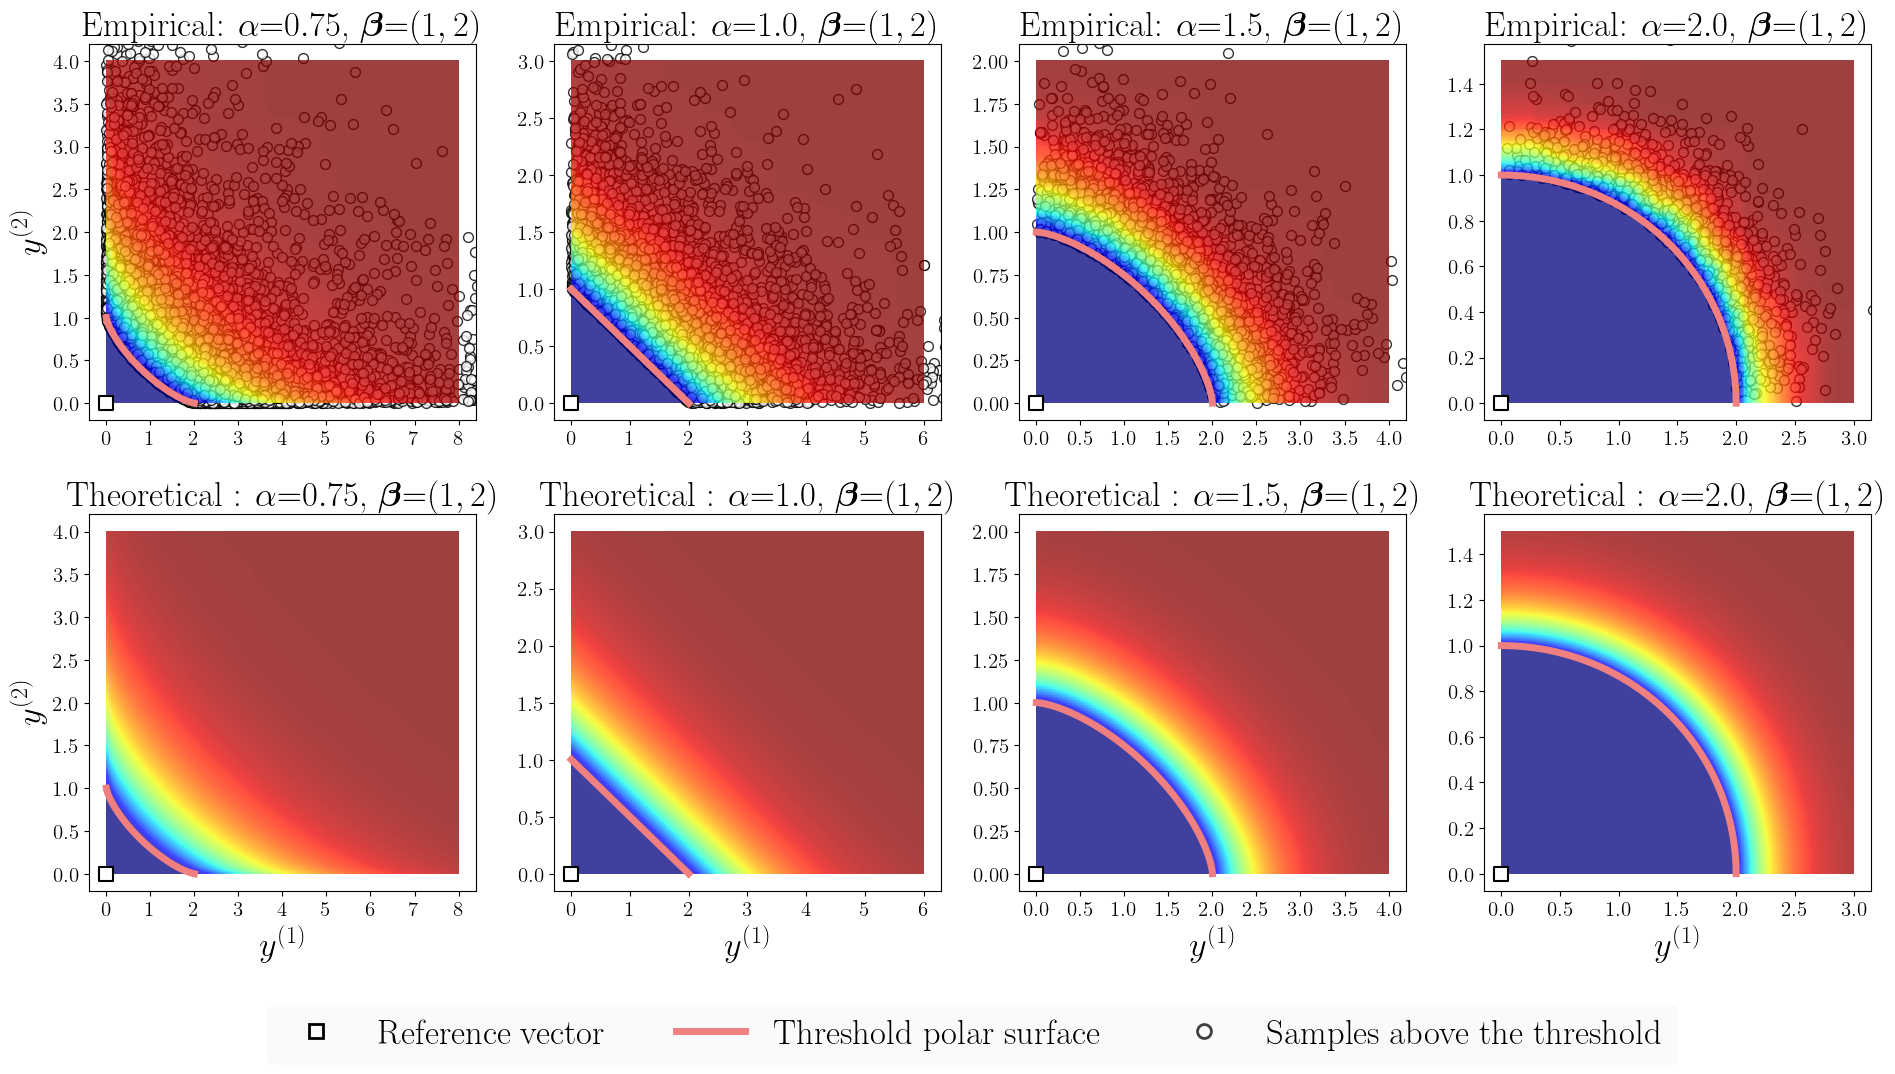

In [4]:
num_rows = 2
num_cols = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(23, 11), rasterized=True)

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.25
)

for col, shape in enumerate(shapes):
    for row in range(2):
        index = row * num_cols + col
        plt.subplot(num_rows, num_cols, index + 1)

        plt.plot(
            ref_fronts[shape][:, 0],
            ref_fronts[shape][:, 1],
            linewidth=5,
            color="lightcoral",
            zorder=4,
            linestyle="-",
        )

        mask_upper = masks_upper[shape]
        mask_lower = masks_lower[shape]
        sample_upper = samples[shape][mask_upper]
        sample_lower = samples[shape][mask_lower]
        bound = bounds[shape]

        if row == 0:
            plt.scatter(
                sample_upper[:, 0],
                sample_upper[:, 1],
                alpha=0.8,
                zorder=2,
                color="w",
                s=50,
                edgecolor="k",
            )

            plt.imshow(
                empirical_probs[shape],
                extent=[bound[0, 0], bound[1, 0], bound[0, 1], bound[1, 1]],
                origin="lower",
                cmap="jet",
                alpha=0.75,
                vmin=0.0,
                vmax=1.0,
                aspect="auto",
                zorder=3,
            )
        else:

            plt.imshow(
                theoretical_probs[shape],
                extent=[bound[0, 0], bound[1, 0], bound[0, 1], bound[1, 1]],
                origin="lower",
                cmap="jet",
                alpha=0.75,
                vmin=0.0,
                vmax=1.0,
                aspect="auto",
            )

        plt.scatter(
            nadir[:, 0],
            nadir[:, 1],
            color="w",
            marker="s",
            linestyle="None",
            s=100,
            edgecolors="k",
            linewidth=1.5,
            zorder=5,
        )

        if row == 0:
            plt.title(
                rf"Empirical: $\alpha$=${shape}$, $\boldsymbol{{\beta}}$=$(1,2)$",
                fontsize=25,
            )
        else:
            plt.title(
                rf"Theoretical : $\alpha$=${shape}$, $\boldsymbol{{\beta}}$=$(1,2)$",
                fontsize=25,
            )
        if col == 0:
            plt.ylabel(r"$y^{(2)}$", fontsize=25)
        if row == num_rows - 1:
            plt.xlabel(r"$y^{(1)}$", fontsize=25)

        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

        plt.xlim(plot_bounds[shape][:, 0])
        plt.ylim(plot_bounds[shape][:, 1])

#########################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference vector",
)

pink_line = mlines.Line2D(
    [],
    [],
    color="lightcoral",
    linestyle="-",
    linewidth=5,
    alpha=1.0,
    label=r"Threshold polar surface",
)

black_dots = mlines.Line2D(
    [],
    [],
    color="w",
    marker="o",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    alpha=0.75,
    label=r"Samples above the threshold",
)

gray_dots = mlines.Line2D(
    [],
    [],
    color="gray",
    marker="o",
    linestyle="None",
    markersize=10,
    markeredgecolor="gray",
    markeredgewidth=2,
    alpha=0.75,
    label=r"Samples below the threshold",
)

axes[num_rows - 1, 0].legend(
    handles=[
        (white_square),
        (pink_line),
        (black_dots),
    ],
    ncol=3,
    fontsize=25,
    loc=(0.46, -0.46),
    facecolor="k",
    framealpha=0.02,
)

plt.show()